# test implementations 

In [1]:
import json
import numpy as np
import pandas as pd
import time

import sklearn as skl
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns

import matplotlib.pyplot as plt

#Our implementations
import kNN as OurKNN
import RidgeRegression as OurRidge

cross_validator10 = skl.model_selection.StratifiedKFold(n_splits=10)


#### Dataset 1: Wikipedia maths
Json structure:
{"edges":[[x,y]... array of ordered tuples of links],
"weights":[(ordered) array of weights for the edges, I guess they represent the number of times one topic is linked to another],
"node_ids":{"topic name": id, set of ids for all topics},
"time_periods":731,
"0": {"index":0, "year":2019, "month": 3, "day":16, "y":[124, 1240, 123...]},
"1":{"index":1, ...}
...
}

In [4]:
# Load data, process, potentially plot some distributions
# 731 days * 1068 topics = 780708 instances

with open('data/wikivital_mathematics.json') as data_file:    
    math_data = json.load(data_file)
    
keys = math_data.keys()

topics_id = math_data["node_ids"]
topics = math_data["node_ids"].keys()

X = []
Y = []

prev_total_visitors = 0
for day in range(int(math_data['time_periods'])):
    day_data = math_data[str(day)]
    
    index = day_data['index']
    year = day_data['year']
    month = day_data['month']
    date = day_data['day']
    weekday = index % 7
    
    #Calculate the number of visitors this day as target + feature for next day.
    total_visitors = 0
    for visitors in day_data['y']:
        total_visitors = total_visitors + int(visitors)
    
    #We can't use first day since 
    if(index>0):
        # 
        x = [index, year, month, date]
        
        # One hot encode weekday
        for i in range(7):
            if(i == weekday):
                x.append(1)
            else:
                x.append(0)
        
        x.append(prev_total_visitors)
                  
        X.append(x)
        Y.append(total_visitors)
        
    prev_total_visitors = total_visitors

X = np.array(X)
Y = np.array(Y)

#Preprocess features. scale to [-1, 1]
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler.fit(X)
X = scaler.transform(X)

#Preprocess target. Subtract mean.
Y = Y - np.mean(Y)



        
    

#### Dataset 2: Energy efficiency

In [2]:
# Load data, process, potentially plot some distributions

df_raw = pd.read_csv('data/energy_efficiency_data.csv')
num_entries = df_raw.shape[0]
num_attributes = df_raw.shape[1]

df_shuffeled = df_raw.sample(frac=1,random_state=193520285)

#Preprocess target: Pick one of two possible targets, mean = 0 
Y = df_shuffeled.values[:,-2:-1]
Y = np.reshape(Y, len(Y))
Y = Y - np.mean(Y)

#Preprocess features. Scale all to [0,1]
X = df_shuffeled.values[:,:-2]
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler.fit(X)
X = scaler.transform(X)


{'L1': [0, 22.638321691654813, 22.494229354480147, 20.823325877263564, 18.305842301977734, 17.638342260970834, 19.561102519004177, 19.464893455085225, 20.466632593976854, 20.312712064579124, 20.480663688101334], 'L2': [0, 64.52165958085553, 41.25145765973643, 35.08750186507187, 36.21535187067902, 34.60521209010561, 33.21103132123162, 34.92745175845753, 33.409705314548226, 34.21193417717578, 33.04178809172828], 'L_inf': [0, 40.29743614129287, 35.86206622183808, 38.318901043642924, 35.8455067294215, 36.472291674966655, 35.54579916970325, 35.54023310700042, 34.92469983487207, 34.867093659320744, 35.16297030401938]}


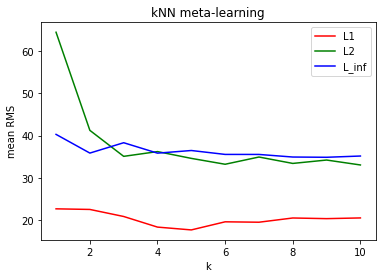

In [9]:
# Meta KNN

#rms = OurKNN.metaKNN(X,Y)

ks = range(1,11)

print(rms)
plt.figure(0)
plt.plot(ks, rms['L1'][1:], 'r')
plt.plot(ks, rms['L2'][1:], 'g')
plt.plot(ks, rms['L_inf'][1:], 'b')

plt.legend(['L1', 'L2', 'L_inf'])
plt.xlabel('k')
plt.ylabel('mean RMS')
plt.title("kNN meta-learning")

plt.savefig("plots/energy/metaKNN.png")
plt.show()         


In [ ]:
# Ridge regression, own and available implementation + plot

learning_rate = 0.00009
lambda_parameter = 10.00 
max_iterations = 400

    
# Fit models
OurRidge.fit(X,Y, lambda_parameter, learning_rate, max_iter = max_iterations, quiet=False)
    
#availableRidge = Ridge(lambda_parameter, fit_intercept=False, max_iter=max_iterations)
#availableRidge.fit(X[train_index],Y[train_index])
    
#Test models


In [ ]:
# kNN 

OurKNN.fit(X,Y)


#### Dataset 3:

In [25]:
# Load data, process, potentially plot some distributions

features_raw = pd.read_csv('data/wind_power_features.csv')
target_raw   = pd.read_csv('data/wind_power_target.csv')
num_entries = features_raw.shape[0]
num_attributes = features_raw.shape[1]

dataset_size = 10000

#Preprocess target: Pick one of two possible targets, mean = 0 
Y = target_raw.values[:dataset_size,1]
Y = Y - np.mean(Y)

#Preprocess features. Scale all to [-1,1]. Impute with mean
X = features_raw.values[:dataset_size,1:]
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler.fit(X)
X = scaler.transform(X)
imp = SimpleImputer(missing_values = np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)

print("Loaded wind power data.")

Loaded wind power data.


In [ ]:
# Ridge regression, own and available implementation + plot

learning_rate = 0.0000001
lambda_parameter = 100.00 
max_iterations = 400

#Fit models
cv=KFold(n_splits=5, shuffle=True, random_state=42)
our_time=[]
skl_time=[]

pred_df=pd.DataFrame(columns =[0,1,2])

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
        
    # Fit models
    start=time.time()
    OurRidge.fit(X_train,y_train, lambda_parameter, learning_rate, max_iter = max_iterations, quiet=False)
    our_pred=OurRidge.regress_all(X_test)
    our_time.append(time.time()-start)
        
    start=time.time()
    availableRidge = Ridge(lambda_parameter, fit_intercept=False, max_iter=max_iterations)
    availableRidge.fit(X_train,y_train)
    skl_pred=availableRidge.predict(X_test)
    skl_time.append(time.time()-start)
        
    pred_df=pd.concat([pred_df,pd.DataFrame(list(zip(y_test,our_pred,skl_pred)))],axis=0)
    
    break